In [39]:
from os import listdir
import os, os.path as osp
from PIL import Image, ImageDraw
from tqdm import tqdm
import ast

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from matplotlib import animation, rc
rc('animation', html='jshtml')

from utils.logger import init_logger
log_level = "DEBUG"
logger = init_logger("Data", log_level)

In [40]:
#### CSTE
CREATE_VIDEO = False

In [41]:
def validate_images(video_id):
    """
    Validate if there is corrupted data
    from https://www.kaggle.com/diegoalejogm/great-barrier-reefs-eda-with-animations
    """
    path = osp.join(path_videos, f"video_{video_id}")
    
    logger.info(f"Verifying that video {video_id} frames are valid...")
    for filename in tqdm(listdir(path), leave=True):
        if filename.endswith('.jpg'):
            try:
                img = Image.open(osp.join(path,filename))
                img.verify() # Verify it is in fact an image
            except (IOError, SyntaxError) as e:
                logger.warning('Bad file:', filename) # Print out the names of corrupt files
    logger.info(f"Verified! Video {video_id} has all valid images")

def fetch_image_list(df_tmp, video_id, list_frame_id):
    """
    Load sequence of images with annotations
    """
    def fetch_image(frame_id):
        path_base = osp.join(path_videos, "video_{}/{}.jpg")
        raw_img = Image.open(path_base.format(video_id, frame_id))

        row_frame = df_tmp[(df_tmp.video_id == video_id) & (df_tmp.video_frame == frame_id)].iloc[0]
        bounding_boxes = ast.literal_eval(row_frame.annotations)

        for box in bounding_boxes:
            draw = ImageDraw.Draw(raw_img)
            x0, y0, x1, y1 = (box['x'], box['y'], box['x']+box['width'], box['y']+box['height'])
            draw.rectangle((x0, y0, x1, y1), outline=180, width=5)
        return raw_img

    return [np.array(fetch_image(index)) for index in list_frame_id]

def create_video(ims):
    """
    from https://www.kaggle.com/diegoalejogm/great-barrier-reefs-eda-with-animations
    """
    fig = plt.figure(figsize=(9, 9))
    plt.axis('off')
    im = plt.imshow(ims[0])

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//12)

In [42]:
# Init path 
root_path_data = "assets/tensorflow-great-barrier-reef/"
path_videos = osp.join(root_path_data, "train_images")
annotations = osp.join(root_path_data, "train.csv")

# Check annotations
df_train_raw = pd.read_csv(annotations)
logger.info(f"Train data :\n {df_train_raw}")

logger.info(f"Duplicate data : {df_train_raw.duplicated().sum()}")

nb_video = list(pd.unique(df_train_raw.video_id))

# Check images
for video_id in range(len(nb_video)):
    validate_images(video_id)

11:53:47 [INFO]		Data	Train data :
        video_id  sequence  video_frame  sequence_frame image_id annotations
0             0     40258            0               0      0-0          []
1             0     40258            1               1      0-1          []
2             0     40258            2               2      0-2          []
3             0     40258            3               3      0-3          []
4             0     40258            4               4      0-4          []
...         ...       ...          ...             ...      ...         ...
23496         2     29859        10755            2983  2-10755          []
23497         2     29859        10756            2984  2-10756          []
23498         2     29859        10757            2985  2-10757          []
23499         2     29859        10758            2986  2-10758          []
23500         2     29859        10759            2987  2-10759          []

[23501 rows x 6 columns]
11:53:47 [INFO]		Data	Trai

In [43]:
stats = []
# Retrieve images
for video_id in tqdm(range(len(nb_video)), position=0, desc="Video", leave=True):

    df_video = df_train_raw[df_train_raw.video_id == video_id]
    sequences = pd.unique(df_video.sequence)
    
    for seq in tqdm(sequences, position=1, desc="Sequence", leave=True):
        
        df_seq = df_video[df_video.sequence == seq]
        
        img_vid_frame = df_seq.video_frame 
        nb_BB = sum([len(ast.literal_eval(bb)) for bb in np.asarray(df_seq.annotations)])
        
        stats.append({"Video_ID": video_id, "Sequence": seq, "len_seq": len(img_vid_frame), "nb BB": nb_BB})
        # logger.info(f"Video ID: {video_id}, Sequence: {seq}, len sequence: {len(img_vid_frame)}, Nb BB: {nb_BB}")

        if CREATE_VIDEO:
            images = fetch_image_list(df_train_raw, video_id = video_id, list_frame_id = img_vid_frame)

            video = create_video(images)

            output_path = osp.join("video_annotations", f"video_{video_id}")
            os.makedirs(output_path, exist_ok=True)
            video.save(osp.join(output_path, f"sequence_{seq}.mp4"))
            logger.info(f"{osp.join(output_path, f'sequence_{seq}.mp4')} written !")

df_stats = pd.DataFrame(stats)
logger.info(f"Statistics database:\n {df_stats}")

Video: 100%|██████████| 3/3 [00:00<00:00, 14.43it/s]
11:53:49 [INFO]		Data	Statistics database:
     Video_ID  Sequence  len_seq  nb BB
0          0     40258      480    315
1          0     45518      798    123
2          0     59337      537    193
3          0      8399     1423    896
4          0     45015      617     24
5          0     35305      853     89
6          0     53708     1077   1146
7          0       996      923    279
8          1     60510     1167    113
9          1     44160      151      0
10         1     15827      770     74
11         1     29424      184      0
12         1      8503     2843   3195
13         1     18048       71    115
14         1     17665       87    255
15         1     60754     2959   2632
16         2     37114     2800      0
17         2     26651     1525     29
18         2     22643     1248   2349
19         2     29859     2988     71
11:53:49 [INFO]		Data	Statistics database:
     Video_ID  Sequence  len_seq  nb BB
0

In [79]:
import seaborn as sns
import matplotlib as mpl

In [98]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal
    from https://www.kaggle.com/andradaolteanu/greatbarrierreef-full-guide-to-bboxaugmentation/notebook#3.-Bounding-Box-Augmentation
    '''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

font_size = 18
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': font_size})

# Frames per video and per sequence

In [99]:
frames_total = []
for i in range(3):
    frames_total.append(df_stats[df_stats['Video_ID']==i]['len_seq'].sum())

df = pd.DataFrame(data=np.array(frames_total), index=[list(df_stats['Video_ID'].unique())], columns=['Frames'])
print(df)

nb_BB_total = []
for i in list(df_stats['Sequence']):
    nb_BB_total.append(df_stats[df_stats['Sequence']==i]['len_seq'])

df = pd.DataFrame(data=np.array(nb_BB_total), index=[list(df_stats['Sequence'])],columns=['Frames'])
print(df.sort_values('Frames', ascending=False))


   Frames
0    6708
1    8232
2    8561
       Frames
29859    2988
60754    2959
8503     2843
37114    2800
26651    1525
8399     1423
22643    1248
60510    1167
53708    1077
996       923
35305     853
45518     798
15827     770
45015     617
59337     537
40258     480
29424     184
44160     151
17665      87
18048      71


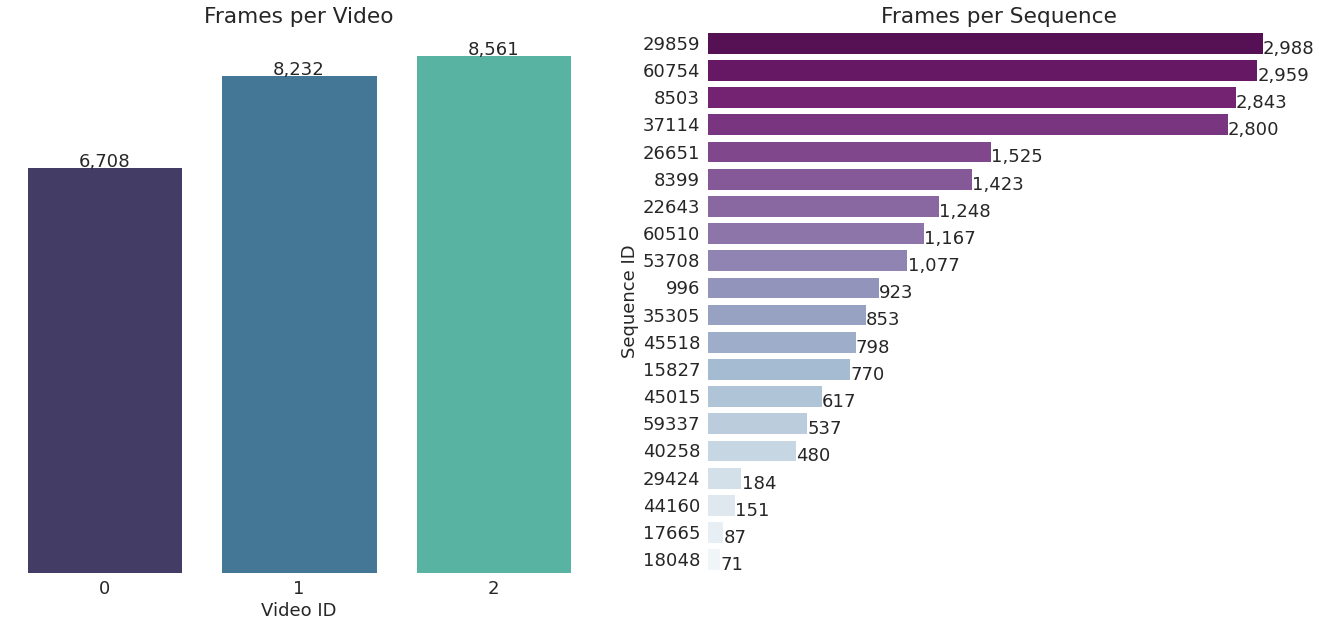

In [101]:
"""
https://www.kaggle.com/andradaolteanu/greatbarrierreef-full-guide-to-bboxaugmentation/notebook#3.-Bounding-Box-Augmentation
"""

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))

df1 = df_train_raw["video_id"].value_counts().reset_index()

sns.barplot(data=df1, x="index", y="video_id", ax=ax1, palette="mako")
show_values_on_bars(ax1, h_v="v", space=0.1)
ax1.set_xlabel("Video ID")
ax1.set_ylabel("")
ax1.title.set_text("Frames per Video")
ax1.set_yticks([])

df2 = df_train_raw["sequence"].value_counts().reset_index()

sns.barplot(data=df2, y="index", x="sequence", order=df2["index"],
            ax=ax2, orient="h", palette="BuPu_r")
show_values_on_bars(ax2, h_v="h", space=0.4)
ax2.set_xlabel("")
ax2.set_ylabel("Sequence ID")
ax2.title.set_text("Frames per Sequence")
ax2.set_xticks([])

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax1)
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax2)

# NB BBox per video per sequence

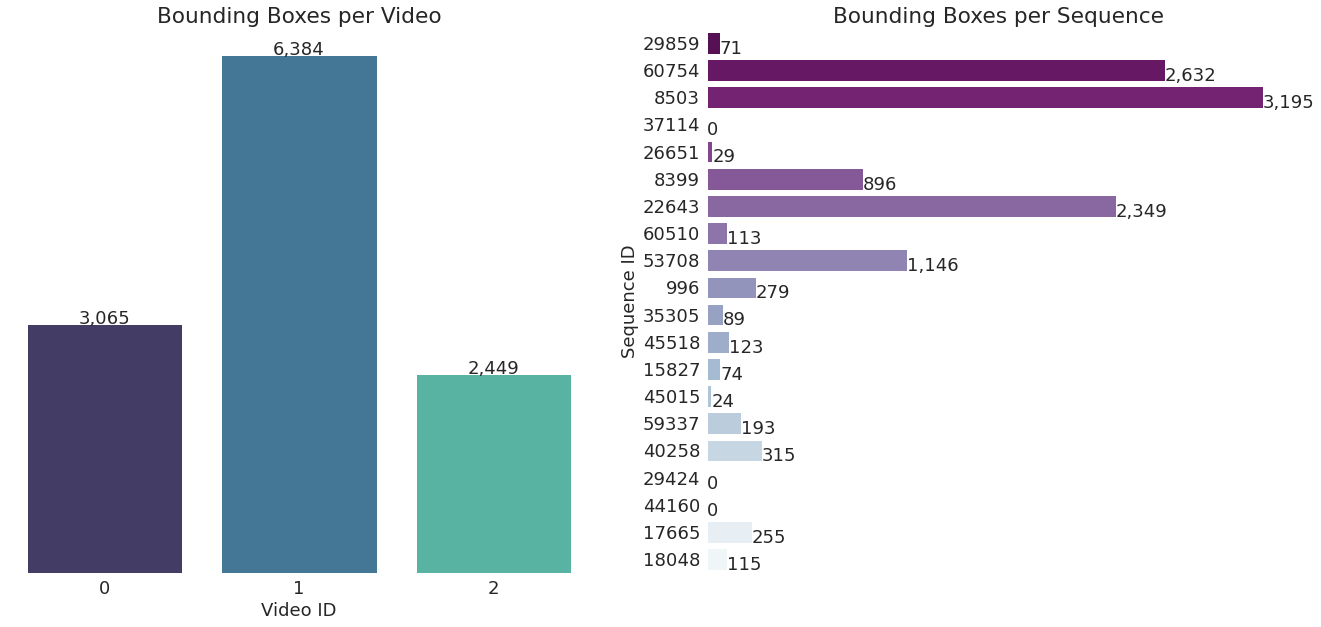

In [131]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))

df1bis = pd.DataFrame(columns = ['index', 'video_id'])

df1bis['index'] = list(df_stats['Video_ID'].unique())

list_bb =[df_stats[df_stats['Video_ID']==i]['nb BB'].sum() for i in range(3)]

df1bis['video_id'] = list_bb

sns.barplot(data=df1bis, x="index", y="video_id", ax=ax1, palette="mako")
show_values_on_bars(ax1, h_v="v", space=0.1)
ax1.set_xlabel("Video ID")
ax1.set_ylabel("")
ax1.title.set_text("Bounding Boxes per Video")
ax1.set_yticks([])

df2bis = pd.DataFrame(columns = ['index', 'sequence_id'])

df2bis['index'] = list(df_stats['Sequence'].unique())

list_bb =[df_stats[df_stats['Sequence']==i]['nb BB'].sum() for i in list(df_stats['Sequence'].unique())]

df2bis['sequence_id'] = list_bb

sns.barplot(data=df2bis, y="index", x="sequence_id", order=df2["index"],
            ax=ax2, orient="h", palette="BuPu_r")

show_values_on_bars(ax2, h_v="h", space=0.4)
ax2.set_xlabel("")
ax2.set_ylabel("Sequence ID")
ax2.title.set_text("Bounding Boxes per Sequence")
ax2.set_xticks([])

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax1)
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax2)